# Asynchronous optimization

Asynchronous optimization methods date back to the 60s, although it is only recently that they have found widespread adoption in machine learning. The difference between asynchronous and synchronous methods is that asynchronous methods do not need to wait for other tasks to complete.

![](async.png)

A method that has gained widespread popularity in recent years is Hogwild!.

Hogwild! is a variant of stochastic gradient descent (SGD) in which each core performs an optimization 



## References

* Niu et al., [HOGWILD!: A Lock-Free Approach to Parallelizing Stochastic Gradient Descent](http://papers.nips.cc/paper/4390-hogwild-a-lock-free-approach-to-parallelizing-stochastic-gradient-descent.pdf) Niu et al., NIPS 2011

* Leblond, Rémi, Fabian Pedregosa, and Simon Lacoste-Julien. ["ASAGA: Asynchronous parallel saga."](https://arxiv.org/pdf/1606.04809.pdf), AISTATS 2017

* Dean, Jeffrey, et al. ["Large scale distributed deep networks."](http://static.googleusercontent.com/media/research.google.com/en/us/archive/large_deep_networks_nips2012.pdf) Advances in neural information processing systems. 2012.

* ASAGA



In [1]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


# threading vs multiprocessing

In python there are two ways to perform parallel computations: threading and multiprocessing. We have used multiprocessing in the last session: it duplicates the python virtual machine and performs all needed operations in a separate process. Unfortunately, for algorithms like Hogwild!, we will need the different workers to update the same vector of coefficients, which is not straightforward to do with multiprocessing.

Threading does not duplicate the memory and makes it easier to share variables between workers. Unfortunately, because of the [global interpreter lock (GIL)](https://en.wikipedia.org/wiki/Global_interpreter_lock) it is not possible to concurrently execute python instructions (such as numpy operations). It is however possible to concurrently use code that is compiled, such as the one generated by Numba. We will see how this is possible using the decorator ```njit(nogil=True)```.

The code below downloads a real-world dataset and loads it into memory. Alternatively, you can manually download the dataset from http://s3-eu-west-1.amazonaws.com/copt.bianp.net/datasets/rcv1_full.binary.bz2 and load it using ```sklearn.datasets.load_svmlight_file(file_path)```

In [2]:
import os, hashlib

# load a large, sparse dataset such as RCV1
def load_rcv1(md5_check=True):
    from os.path import expanduser
    home = expanduser("~")
    dir_name = os.path.join(home, 'copt_data')
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    file_path = os.path.join(dir_name, 'rcv1_full.binary.bz2')
    if not os.path.exists(file_path):
        print('RCV1 dataset is not present in data folder. Downloading it ...')
        url = 'http://s3-eu-west-1.amazonaws.com/copt.bianp.net/datasets/rcv1_full.binary.bz2'
        urllib.request.urlretrieve(url, file_path)
        print('Finished downloading')
    if md5_check:
        h = hashlib.md5(open(file_path, 'rb').read()).hexdigest()
        if not h == '6131cf16515e9cce08d112c880b6b817':
            print('MD5 hash do not coincide')
            print('Removing file and re-downloading')
            os.remove(file_path)
            return load_rcv1()
    from sklearn import datasets
    return datasets.load_svmlight_file(file_path)

A, b = load_rcv1()

About the dataset: Reuters Corpus Volume I (RCV1) is an archive of over 800,000 manually categorized newswire stories made available by Reuters, Ltd. for research purposes. The dataset is extensively [described here](http://www.daviddlewis.com/resources/testcollections/rcv1/).

In [3]:
A.shape

(697641, 47236)

The dataset is quite large.

In [4]:
density = A.nnz / (A.shape[0] * A.shape[1])
print('A has density %s' % density )

A has density 0.0015492979884363385


but quite sparse, only about 1% of coefficients are nonzero.

# Sparse matrix structure

In this dataset, X is a sparse matrix. In this matrix structure, only nonzero values are stored.


In [5]:
A

<697641x47236 sparse matrix of type '<class 'numpy.float64'>'
	with 51055210 stored elements in Compressed Sparse Row format>

Different sparse matrix storages can be used. Here we used Compressed Sparse Row (CSR) format.

![](csr_storage_sparse_marix.png)

The matrix is determined by three arrays: the values (A.data), the column indices (A.indices) and row start (A.indptr)

In [6]:
A.data

array([ 0.03390622,  0.04247393,  0.07730481, ...,  0.23907566,
        0.08010465,  0.0387759 ])

In [7]:
A.indices

array([  439,   729,  1522, ..., 45944, 46096, 46158], dtype=int32)

In [8]:
A.indptr

array([       0,      181,      322, ..., 51054887, 51055090, 51055210], dtype=int32)

One can use sparse matrices as numpy arrays most of the time ...

In [9]:
def loss_logistic(x):
    p = b * A.dot(x)
    return -np.sum(np.log(1.0 / (1.0 + np.exp(-p))))

loss_logistic(np.zeros(A.shape[1]))


483567.89219302108

# Hogwild!

The basis of Hogwild! is the stochastic gradient descent algorithm on a least squares problem. We will start by coding such an algorithm using numba.

In the hogwild algorithm, each core selects an index $i$ at random and performs the iteration

$$
\theta^+ = \theta - \gamma \nabla l_i(\theta)
$$

The loss function $l_i$ for linear models such as least squares and logistic regression are of the form
$$
l_i(\theta) = f(a_i x) \quad,
$$
and so its gradient is determined by
$$
\nabla l_i(\theta) = \underbrace{a_i}_{sparse} \underbrace{f'(a_i x)}_{\text{scalar}} \quad.
$$

This means that when the $a_i$ are sparse, so will be the partial gradients. I  practice, we will not compute the full gradient but only the scalar part, as the sparse part does not depend on $x$ and will be computed at run-time. This is a fundamental idea behind Hogwild!.

In previous algorithms, **we have not worried about sparsity**. This time, we will take it into consideration. This will make the algorithm much more efficient. Unfortunately, it will also make the code significantly more complex.


In [30]:
from numba import njit


@njit
def partial_gradient(p, b):
    # compute p
    p *= b
    if p > 0:
        phi = 1. / (1 + np.exp(-p))
    else:
        exp_t = np.exp(p)
        phi = exp_t / (1. + exp_t)
    return (phi - 1) * b


@njit(nogil=True)
def sgd(theta, A_data, A_indices, A_indptr, b, max_iter=20, step_size=1e-3):
    n_samples = b.size
    grad_history = np.zeros(max_iter)
    for it in range(max_iter):
        # .. compute full gradient for convergence monitoring ..
        grad = np.zeros(theta.size)
        for i in range(n_samples):
            # .. compute ax ..
            p = 0.
            for j in range(A_indptr[i], A_indptr[i+1]):
                j_idx = A_indices[j]
                p += theta[j_idx] * A_data[j]
            grad_i = partial_gradient(p, b[i])
            for j in range(A_indptr[i], A_indptr[i+1]):
                j_idx = A_indices[j]
                grad[j_idx] += A_data[j] * grad_i / n_samples        
        grad_history[it] = np.linalg.norm(grad)

        for _ in range(n_samples):
            # .. select random index ..
            i = np.random.randint(0, n_samples)

            # .. compute ax ..
            p = 0.
            for j in range(A_indptr[i], A_indptr[i+1]):
                j_idx = A_indices[j]
                p += theta[j_idx] * A_data[j]

            # .. compute f'(a_i x)
            grad_i = partial_gradient(p, b[i])

            # apply sparse update
            for j in range(A_indptr[i], A_indptr[i+1]):
                j_idx = A_indices[j]
                theta[j_idx] = theta[j_idx] - step_size * (A_data[j] * grad_i)

    return theta, grad_history


In [31]:
theta = np.zeros(A.shape[1])
theta, grad_history = sgd(theta, A.data, A.indices, A.indptr, b)

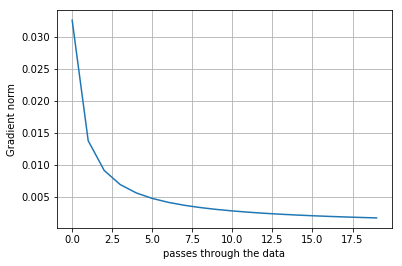

In [32]:
plt.plot(grad_history)
plt.grid()
plt.ylabel('Gradient norm')
plt.xlabel('passes through the data')
plt.show()

# Parallel execution using threads

the nogil directive specified before allows us to use to execute the above code in parallel

In [33]:
import concurrent.futures

theta_2 = np.zeros(A.shape[1])
futures = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures.append(executor.submit(sgd, theta_2, A.data, A.indices, A.indptr, b))
    futures.append(executor.submit(sgd, theta_2, A.data, A.indices, A.indptr, b))
concurrent.futures.wait(futures)
_, grad_history_2 = futures[0].result()

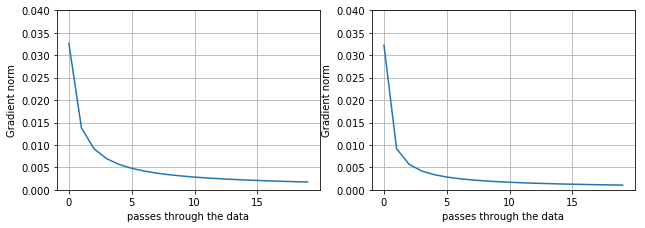

In [35]:
plt.figure(figsize=(16, 3.3))
plt.subplot(131)
plt.plot(grad_history)
plt.grid()
plt.ylim(0, 0.04)
plt.ylabel('Gradient norm')
plt.xlabel('passes through the data')
plt.subplot(132)
plt.plot(grad_history_2)
plt.ylim(0, 0.04)
plt.grid()
plt.ylabel('Gradient norm')
plt.xlabel('passes through the data')
plt.show()